In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ['CUDA_HOME'] = '/home/jovyan/vasiliev/notebooks/Show-o/cuda_fake'
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'|

In [2]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from models import Showo
from training.prompting_utils import UniversalPrompting, create_attention_mask_predict_next
from training.utils import get_config
import json
import argparse
from PIL import Image
import numpy as np
from omegaconf import OmegaConf
from models.clip_encoder import CLIPVisionTower
from transformers import CLIPImageProcessor
from llava.llava import conversation as conversation_lib
from omegaconf import OmegaConf
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List, Dict, Optional


conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]
STATS_TYPES = ['max_abs', 'min_abs', 'var', 'sparsity']

/home/jovyan/vasiliev/notebooks/Show-o/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-10-07 17:57:03,727] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


In [3]:
from inference_mmu import run_mmu
from inference_t2i import run_t2i

In [4]:
config = OmegaConf.load('configs/showo_demo_w_clip_vit_512x512.yaml')

In [5]:
def get_model(config):
    model = Showo.from_pretrained(config.model.showo.pretrained_model_path)
    model.eval()
    return model

In [6]:
class Stats:
    def __init__(self, device: str = "cpu"):
        self._lists: Dict[str, List[torch.Tensor]] = {name: [] for name in STATS_TYPES}
        self.device = device

    def append(self, name: str, tensor: torch.Tensor) -> None:
        if name not in self._lists:
            raise KeyError(f"Unknown stat name '{name}'")
        self._lists[name].append(tensor.detach().to('cpu'))

    def append_many(self, stats: Dict[str, torch.Tensor]) -> None:
        for k, v in stats.items():
            if v is None:
                continue
            self.append(k, v)

    @torch.no_grad()
    def collect_from_tensor(self, out: torch.Tensor, sparsity_eps) -> None:
        max_abs = out.abs().amax(dim=1, keepdim=False)           # (batch_size,)
        var = out.var(dim=1, unbiased=False, keepdim=False)      # (batch_size,)
        sparsity = (out.abs() < sparsity_eps).float().mean(dim=1, keepdim=False)  # (batch_size,)
        min_abs = out.abs().amin(dim=1, keepdim=False)   
        # sparsity = out.abs().amin(dim=1, keepdim=False)   
        self.append("max_abs", max_abs)
        self.append("var", var)
        self.append("sparsity", sparsity)
        self.append("min_abs", min_abs)

    def cat(self, name: str) -> Optional[torch.Tensor]:
        lst = self._lists.get(name)
        if not lst:
            return None
        return torch.cat(lst, dim=0)
    
    def clear(self) -> None:
        for k in list(self._lists.keys()):
            self._lists[k].clear()

    def __repr__(self):
        s = ", ".join(f"{k}: {len(v)}" for k, v in self._lists.items())
        return f"Stats({s})"

In [7]:
class LayerOutputRecorder:
    def __init__(self, device='cuda', sparsity_eps=1e-2):
        # теперь по умолчанию создаётся Stats() для каждого ключа
        self.outputs = defaultdict(lambda: Stats(device=device))
        self.inputs_shapes = defaultdict(list)
        self.handles = []
        self.device = device
        self.sparsity_eps = sparsity_eps

    def build_hook_fn(self, name):
        def hook_fn(module, input_, output):
            with torch.no_grad():
                out = output.detach()
                self.outputs[name].collect_from_tensor(out, sparsity_eps=self.sparsity_eps)
                self.inputs_shapes[name].append(input_[0].shape)
        return hook_fn

    def register_hook(self, module_name, module):
        handle = module.register_forward_hook(self.build_hook_fn(module_name))
        self.handles.append(handle)

    def register_hooks(self, modules: list[tuple[str, torch.nn.Module]]) -> None:
        for module_name, module in modules:
            self.register_hook(module_name, module)

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []

    def clear(self):
        for stats in self.outputs.values():
            stats.clear()
        self.outputs.clear()
        self.inputs_shapes.clear()
        torch.cuda.empty_cache()

In [8]:
def get_target_layers(model) -> list[tuple[str, torch.nn.Module]]:
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            layers.append((name, module))
    return layers

In [9]:
model_t2i = get_model(config)
model_mmu = get_model(config)

The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/jovyan/vasiliev/notebooks/Show-o/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


attention implementation:  sdpa


/home/jovyan/vasiliev/notebooks/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:
The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


In [10]:
# list(model_mmu.named_modules())

In [11]:
target_layers_t2i = get_target_layers(model_t2i)
activations_recorder_t2i = LayerOutputRecorder()
activations_recorder_t2i.register_hooks(target_layers_t2i)

In [12]:
target_layers_mmu = get_target_layers(model_mmu)
activations_recorder_mmu = LayerOutputRecorder()
activations_recorder_mmu.register_hooks(target_layers_mmu)

In [13]:
# mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [14]:
# uv run inference_t2i.py config=configs/showo_demo_w_clip_vit_512x512.yaml mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [15]:
# uv run inference_mmu.py config=configs/showo_demo_w_clip_vit_512x512.yaml max_new_tokens=100 mmu_image_root=./mmu_validation

In [16]:
cfg = OmegaConf.load("configs/showo_demo_w_clip_vit_512x512.yaml")
# cfg.batch_size = 1
cfg.max_new_tokens = 100

cfg_mmu = deepcopy(cfg)
cfg_t2i = deepcopy(cfg)


cfg_t2i.dataset.params.validation_prompts_file="validation_prompts/text2image_prompts.txt"
cfg_t2i.mode = "t2i"
cfg_mmu.mmu_image_root = "./mmu_validation"
cfg_mmu.device = "cuda:0"
cfg_t2i.device = "cuda:0"

In [22]:
def get_activations(recorder, stat: str = "max_abs", layers: list[int] = None):
    if stat not in STATS_TYPES:
        raise ValueError(f"stat must be one of {STATS_TYPES}, got {stat}")
    if layers is None:
        layers = list(range(24))
    layer_names = []
    acts_list = []

    for ind in tqdm(layers, desc=f"collecting {stat}"):
        layer_name = f"showo.model.layers.{ind}.mlp.fc2"
        if layer_name not in recorder.outputs:
            continue

        stats_obj: Stats = recorder.outputs[layer_name]
        t = stats_obj.cat(stat)
        if t is None:
            continue

        t = t.detach().cpu().flatten()
        if t.numel() == 0:
            continue

        layer_names.append(layer_name)
        acts_list.append(t)

    return layer_names, acts_list


def print_stat_boxplots(recorder, stat: str = "max_abs", layers: list[int] = None,
                        figsize=(14,6), showfliers=False):
    layer_names, acts_list = get_activations(recorder, stat=stat, layers=layers)

    if len(acts_list) == 0:
        print("No activations collected for the requested layers/stat.")
        return

    data = [a.numpy() if isinstance(a, torch.Tensor) else np.asarray(a) for a in acts_list]
    plt.figure(figsize=figsize)
    labels = [ln.split(".")[3] if len(ln.split(".")) > 3 else ln for ln in layer_names]
    plt.boxplot(data, labels=labels, showfliers=showfliers)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(stat)
    plt.title(f"Boxplots of '{stat}' across layers ({len(data)} layers)")
    plt.tight_layout()
    plt.show()

In [42]:
def print_all_stats_boxplots(recorder, layers: list[int] = None, figsize=(18,6), showfliers=False):
    # Нормализуем в словарь
    if not isinstance(recorder, dict):
        recorders = {'': recorder}
    else:
        recorders = recorder
    
    stats = list(STATS_TYPES)
    n_stats = len(stats)
    n_recorders = len(recorders)
    
    # 2 строки: boxplots и средние
    fig, axes = plt.subplots(2, n_stats, figsize=(figsize[0], figsize[1] * 1.5), sharey=False)
    if n_stats == 1:
        axes = axes.reshape(-1, 1)
    
    colors = plt.cm.Set2(range(n_recorders))
    
    for col, stat in enumerate(stats):
        ax_box = axes[0, col]
        ax_mean = axes[1, col]
        
        # Собираем данные от всех рекордеров
        recorders_data = {}
        layer_names_all = None
        
        for rec_name, rec in recorders.items():
            layer_names, acts_list = get_activations(rec, stat=stat, layers=layers)
            if len(acts_list) == 0:
                continue
            
            if layer_names_all is None:
                layer_names_all = layer_names
            
            data = [a.numpy() if isinstance(a, torch.Tensor) else np.asarray(a) for a in acts_list]
            recorders_data[rec_name] = data
        
        if len(recorders_data) == 0:
            ax_box.text(0.5, 0.5, f"No data", ha='center', va='center')
            ax_box.set_title(stat)
            ax_mean.text(0.5, 0.5, f"No data", ha='center', va='center')
            continue
        
        # === ВЕРХНИЙ РЯД: Boxplots ===
        n_layers = len(next(iter(recorders_data.values())))
        width = 0.8 / n_recorders
        
        legend_patches = []
        for i, (rec_name, data) in enumerate(recorders_data.items()):
            positions = [j + 1 + (i - n_recorders/2 + 0.5) * width for j in range(n_layers)]
            bp = ax_box.boxplot(data, positions=positions, widths=width*0.9, 
                               showfliers=showfliers, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor(colors[i])
            
            # Создаем патч для легенды
            if rec_name:
                from matplotlib.patches import Patch
                legend_patches.append(Patch(facecolor=colors[i], label=rec_name))
        
        # Метки по оси X
        labels = [ln.split(".")[3] if len(ln.split("."))>3 else ln for ln in layer_names_all]
        ax_box.set_xticks(range(1, n_layers + 1))
        ax_box.set_xticklabels(labels, rotation=45, ha='right')
        ax_box.set_title(stat)
        
        if len(legend_patches) > 0:
            ax_box.legend(handles=legend_patches)
        
        # === НИЖНИЙ РЯД: Графики средних ===
        for i, (rec_name, data) in enumerate(recorders_data.items()):
            means = [d.mean() for d in data]
            x = range(1, len(means) + 1)
            ax_mean.plot(x, means, marker='o', color=colors[i], 
                        label=rec_name if rec_name else None)
        
        ax_mean.set_xticks(range(1, n_layers + 1))
        ax_mean.set_xticklabels(labels, rotation=45, ha='right')
        ax_mean.set_ylabel("Mean")
        ax_mean.grid(True, alpha=0.3)
        
        if len(legend_patches) > 0:
            ax_mean.legend()
    
    plt.tight_layout()
    plt.show()

In [29]:
run_mmu(cfg_mmu, model_mmu)

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


/home/jovyan/vasiliev/notebooks/Show-o/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 0/6 [00:00<?, ?it/s]/home/jovyan/vasiliev/notebooks/Show-o/inference_mmu.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids).to(device).squeeze(0)
 17%|█▋        | 1/6 [00:01<00:07,  1.60s/it]

 The character, Spongebob, appears to be expressing happiness or excitement.


 33%|███▎      | 2/6 [00:02<00:05,  1.44s/it]

 The time of day in the picture is during the day.


 50%|█████     | 3/6 [00:09<00:10,  3.64s/it]

 Yes, it is interacting with something or someone in the image. A dog is standing in a field of flowers, sniffing a flower, and appears to be smelling it. This suggests that the dog is curious and interested in the flower, possibly exploring its surroundings or smelling it as a part of its natural behavior.


 67%|██████▋   | 4/6 [00:10<00:05,  2.88s/it]

 The cat is walking through the snow, moving across the snow-covered ground.


 83%|████████▎ | 5/6 [00:12<00:02,  2.55s/it]

 The path or structure is on a set of train tracks that are surrounded by trees and rocks.


100%|██████████| 6/6 [00:22<00:00,  3.80s/it]

 The scene appears to be surreal, as it is not a typical representation of a living room or a beach setting. Instead, it features a couch, a table, and a potted plant, all placed on a beach-like surface. The couch is positioned in the middle of the scene, and the table is located to the left of the couch. The potted plant is situated to the right of the couch. The combination of these elements creates an unusual and dreamlike atmosphere, as it is
=== Multimodal Understanding Results ===

Image 1: dog.png
Response: User: What emotion does the character seem to express?
 Answer :  The character, Spongebob, appears to be expressing happiness or excitement.

--------------------------------------------------

Image 2: cat.png
Response: User: What is the time of day in the picture?
 Answer :  The time of day in the picture is during the day.

--------------------------------------------------

Image 3: cat.txt
Response: User: Is it interacting with something or someone?
 Answer :  Yes, it i

collecting max_abs: 100%|██████████| 24/24 [00:00<00:00, 849.02it/s]


collecting sparsity: 100%|██████████| 24/24 [00:00<00:00, 941.67it/s]


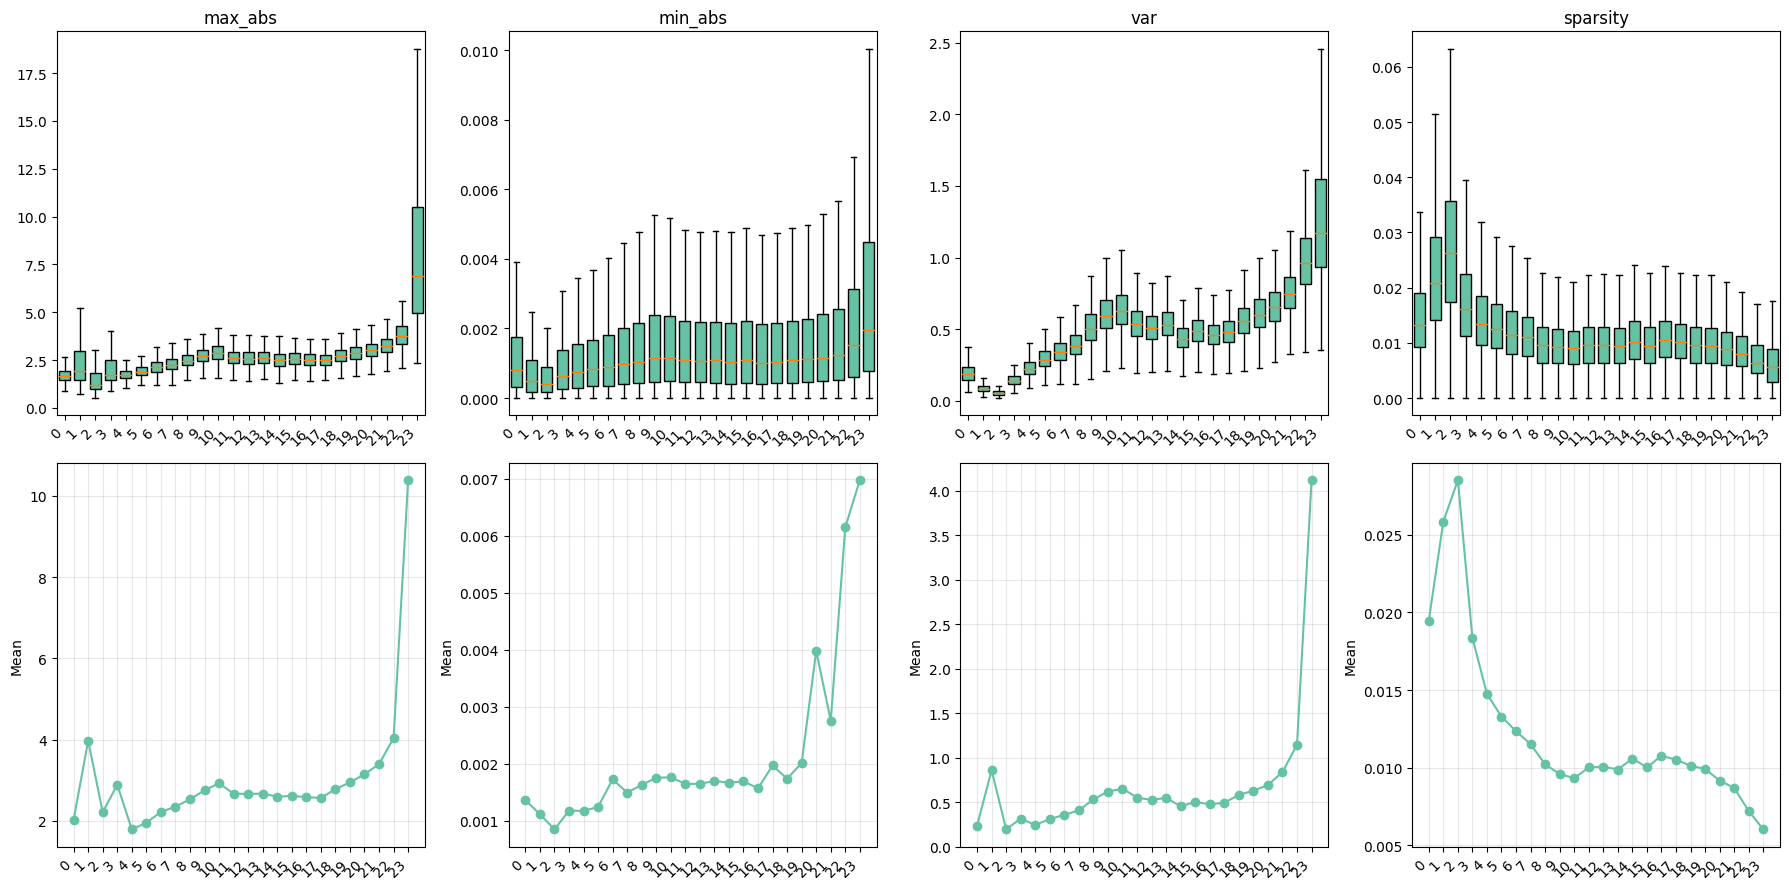

In [43]:
print_all_stats_boxplots(activations_recorder_mmu)

In [20]:
run_t2i(cfg_t2i, model_t2i)

Saving images to: show-o-demo/inference_t2i_20251007_175739
Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

Saved 1 text-to-image results to show-o-demo/inference_t2i_20251007_175739


collecting sparsity: 100%|██████████| 24/24 [00:00<00:00, 17248.68it/s]


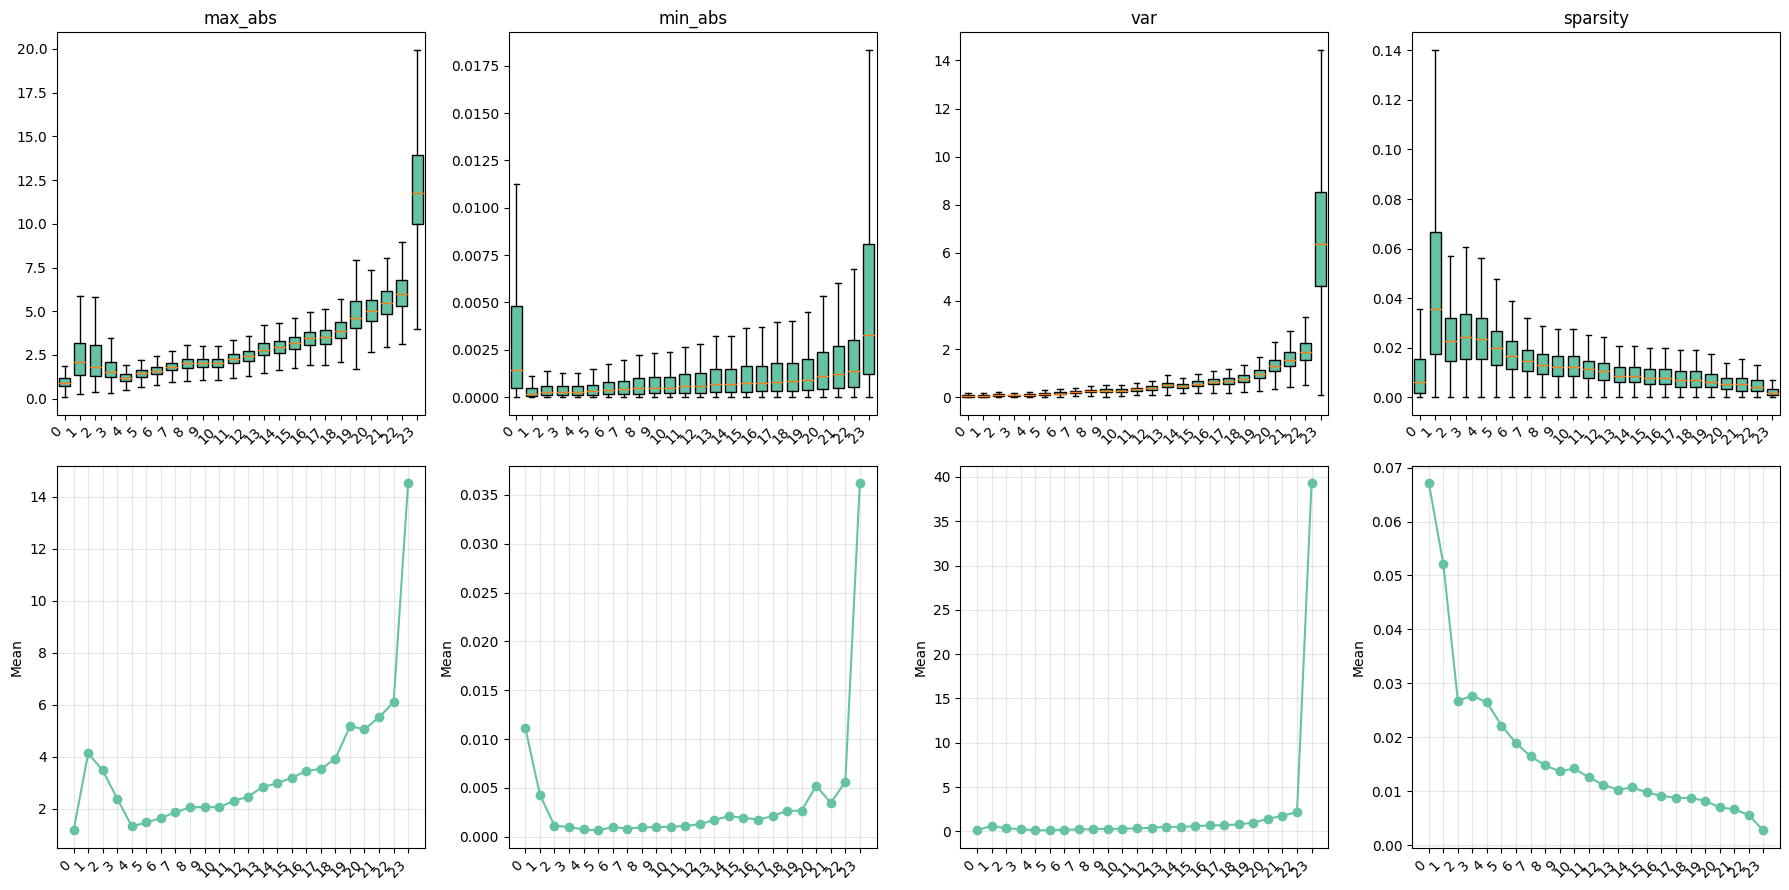

In [45]:
print_all_stats_boxplots(activations_recorder_t2i)

collecting max_abs: 100%|██████████| 24/24 [00:00<00:00, 6842.72it/s]


collecting sparsity: 100%|██████████| 24/24 [00:00<00:00, 10044.23it/s]


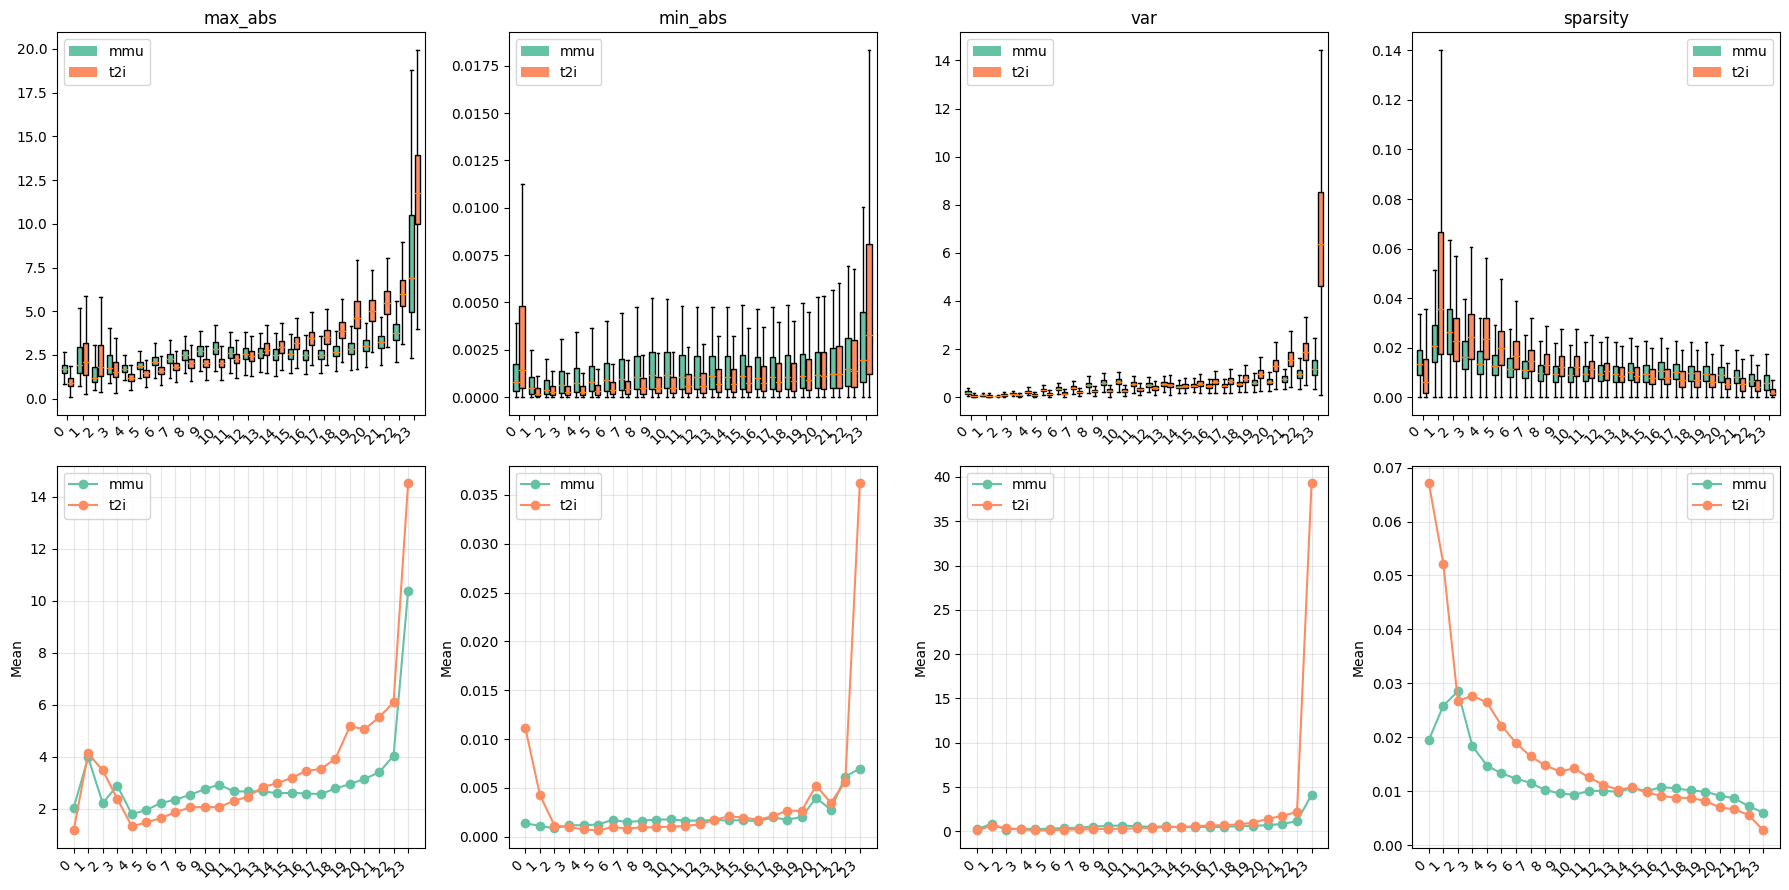

In [44]:
print_all_stats_boxplots({'mmu': activations_recorder_mmu, 't2i': activations_recorder_t2i})